In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from utils.masks import extract_masks, binarize, resample_mask
from utils.images import normalize, resample_img
from utils.registration import est_lin_transf, apply_lin_transf, est_nl_transf, apply_nl_transf
from utils.plot_methods import plot_lin_transf

ImportError: cannot import name 'plot_lin_transf' from 'utils.plot_methods' (/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/utils/plot_methods.py)

In [2]:
def est_nl_transf_t(fix_img, fix_mask, mov_img):

    # initialize the registration
    reg_method = sitk.ImageRegistrationMethod()

    # create initial identity transformation.
    transform_to_displacement_field_filter = sitk.TransformToDisplacementFieldFilter()
    transform_to_displacement_field_filter.SetReferenceImage(fix_img)
    initial_transform = sitk.DisplacementFieldTransform(transform_to_displacement_field_filter.Execute(sitk.Transform()))

    #  regularization. 
    #  The update field refers to fluid regularization; the total field to elastic regularization.
    initial_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0)

    # set the initial transformation
    reg_method.SetInitialTransform(initial_transform)

    # use the function 'SetMetricAsDemons' to be able to perform Demons registration.
    # Provide a parameter (the intensity difference threshold) as input:
    # during the registration, intensities are considered to be equal if their difference is less than the given threshold.
    reg_method.SetMetricAsDemons(10)

    # evaluate the metrics only in the mask, if provided as an input
    # reg_method.SetMetricFixedMask(fix_mask)

    # Multi-resolution framework
    reg_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    reg_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8,4,0])

    # set a linear interpolator
    reg_method.SetInterpolator(sitk.sitkLinear)

    # set a gradient descent optimizer
    reg_method.SetOptimizerAsGradientDescent(learningRate=0.5, numberOfIterations=50, convergenceMinimumValue=1e-6,
                                             convergenceWindowSize=10)
    reg_method.SetOptimizerScalesFromPhysicalShift()

    # perform registration
    final_transform = reg_method.Execute(sitk.Cast(fix_img, sitk.sitkFloat32),
                                                  sitk.Cast(mov_img, sitk.sitkFloat32))

    print("--------")
    print("Demons registration:")
    print('Final metric value: {0}'.format(reg_method.GetMetricValue()))
    print("Optimizer stop condition: {0}".format(reg_method.GetOptimizerStopConditionDescription()))
    print("Number of iterations: {0}".format(reg_method.GetOptimizerIteration()))
    print("--------")    
    return final_transform

In [3]:
fix_img = sitk.ReadImage('./data/common_40_image.nii.gz', sitk.sitkFloat32)
fix_mask = sitk.ReadImage('./data/common_40_mask.nii.gz', sitk.sitkFloat32)
fix_img_data = sitk.GetArrayFromImage(fix_img)
fix_mask_data = sitk.GetArrayFromImage(fix_mask)

In [4]:
mov_img = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/data/g1_53_image.nii.gz',sitk.sitkFloat32)
mov_img_data = sitk.GetArrayFromImage(mov_img)

--------
Linear registration:
Final mean squares value: 158964.01221100797
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 14.
Number of iterations: 14
--------


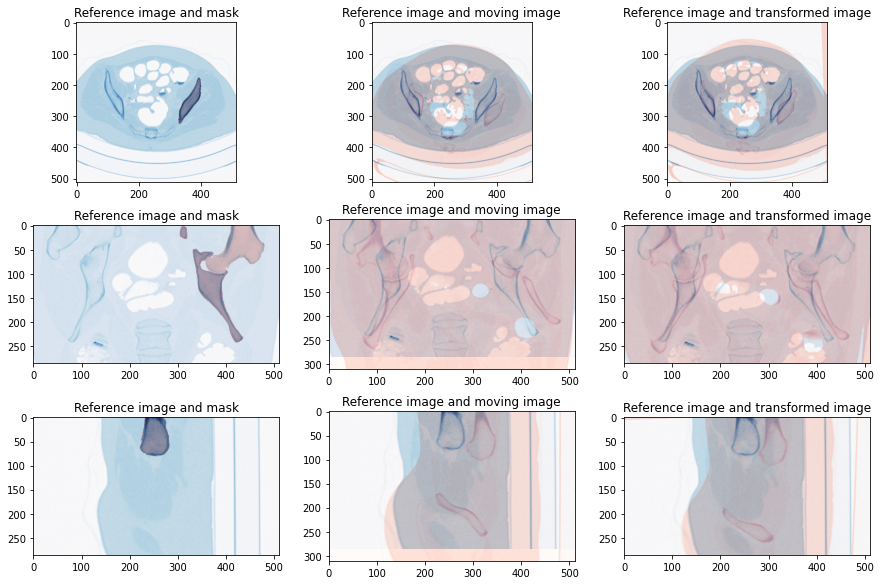

In [11]:
li_transf = est_lin_transf(fix_img, fix_mask, mov_img)
mov_img_resampled = apply_lin_transf(fix_img, mov_img, li_transf)
x,y,z = 140, 250, 450
plot_lin_transf(fix_img, fix_mask, mov_img, mov_img_resampled, x, y, z)

In [17]:
nl_transf = est_nl_transf_t(fix_img, fix_mask, mov_img)
mov_img_resampled = apply_nl_transf(fix_img, mov_img, nl_transf)
x,y,z = 140, 250, 450
plot_lin_transf(fix_img, fix_mask, mov_img, mov_img_resampled, x, y, z)

DemonsImageToImageMetricv4 (0x7fa3b5fa2570): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, verify that the fixed points, once transformed into the virtual domain space, actually lie within the virtual domain.

DemonsImageToImageMetricv4 (0x7fa3b5fa2570): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, verify that the fixed points, once transformed into the virtual domain space, actually lie within the virtual domain.

DemonsImageToImageMetricv4 (0x7fa3b5fa2570): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, verify that the fi